<a href="https://colab.research.google.com/github/Bitdribble/dlwpt-code/blob/master/colab/PyTorchCh8_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
# Data preparation
data_path = '.'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
# Normalize data
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
# Restrict data to airplanes and birds
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

In [5]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [7]:
def training_loop(n_epochs, device, optimizer, model, loss_fn, train_loader, val_loader, log_epochs=0):
  hist = {
      "loss_train" : [],
      "acc_train" : [],
      "acc_val" : [],
  }

  for epoch in range(1, n_epochs + 1):
    model.train() # Set train mode for epoch
    loss_train = 0.0

    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)

      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()

    loss_train /= len(train_loader)

    # Check accuracy. This sets eval mode.
    acc_train, acc_val = validate(model, device, train_loader, val_loader)

    hist["loss_train"].append(loss_train)
    hist["acc_train"].append(acc_train)
    hist["acc_val"].append(acc_val)

    if log_epochs is not 0 and (epoch % log_epochs == 0 or epoch == n_epochs):
      print(f"{datetime.datetime.now()} Epoch {epoch}, "
            f"Loss train {loss_train:.3f} Acc train {acc_train:.3f} val {acc_val:.3f}")
      
  return hist

def validate(model, device, train_loader, val_loader):
  acc = {}
  model.eval() # Set eval mode

  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad(): 
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)

        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1) 

        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    acc[name] = correct / total
  
  return acc["train"], acc["val"]

In [8]:
# Baseline network
class Net(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()

    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)

    self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8*8*(self.n_chans1//2)) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [11]:
model = Net().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

loss_fn = nn.CrossEntropyLoss()

hist = training_loop(
    n_epochs = 40,
    device=device,
    optimizer = optimizer,
    model = model,

    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 01:46:31.116881 Epoch 1, Loss train 0.500 Acc train 0.805 val 0.817
2022-01-31 01:46:32.565183 Epoch 2, Loss train 0.443 Acc train 0.824 val 0.828
2022-01-31 01:46:34.007790 Epoch 3, Loss train 0.426 Acc train 0.813 val 0.812
2022-01-31 01:46:35.453285 Epoch 4, Loss train 0.427 Acc train 0.779 val 0.764
2022-01-31 01:46:36.901202 Epoch 5, Loss train 0.426 Acc train 0.803 val 0.795
2022-01-31 01:46:38.346778 Epoch 6, Loss train 0.410 Acc train 0.810 val 0.815
2022-01-31 01:46:39.799689 Epoch 7, Loss train 0.416 Acc train 0.822 val 0.829
2022-01-31 01:46:41.251152 Epoch 8, Loss train 0.405 Acc train 0.822 val 0.823
2022-01-31 01:46:42.700131 Epoch 9, Loss train 0.398 Acc train 0.830 val 0.826
2022-01-31 01:46:44.147225 Epoch 10, Loss train 0.411 Acc train 0.819 val 0.822
2022-01-31 01:46:45.595093 Epoch 11, Loss train 0.400 Acc train 0.824 val 0.830
2022-01-31 01:46:47.045919 Epoch 12, Loss train 0.387 Acc train 0.821 val 0.811
2022-01-31 01:46:48.504428 Epoch 13, Loss train 0

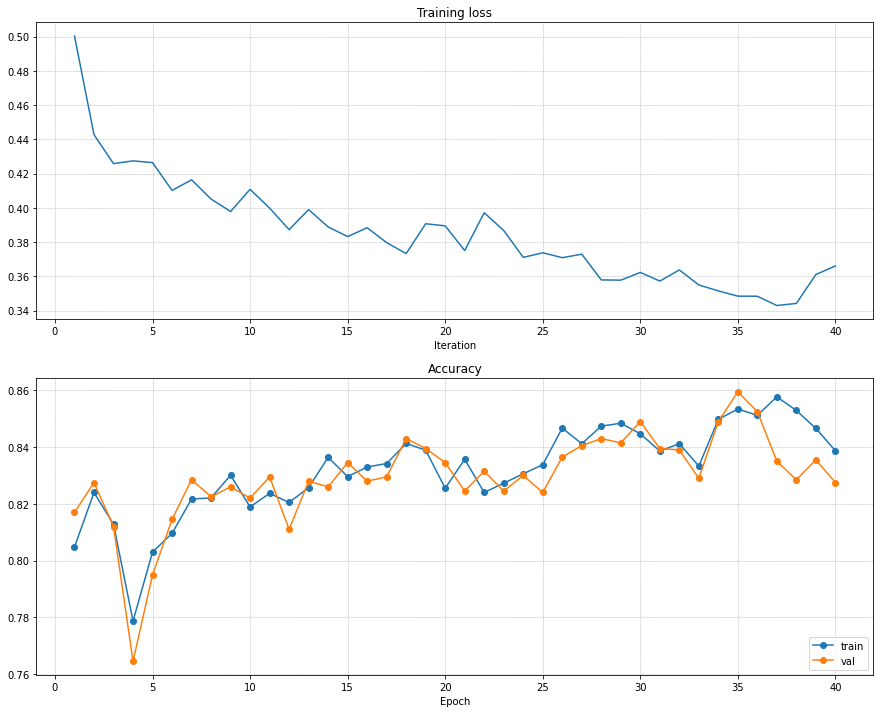

In [12]:
dim = range(1, len(hist["loss_train"])+1)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(dim, hist["loss_train"])
plt.xlabel('Iteration')
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(dim, hist["acc_train"], '-o', label='train')
plt.plot(dim, hist["acc_val"], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

In [9]:
# This implements Batch Normalization 
class NetBatchNorm(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()

    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1) # Batch normalization
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2) # Batch normalization
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)

    self.fc1 = nn.Linear(8*8*(n_chans1//2), 32)
    self.act3 = nn.Tanh()

    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1_batchnorm(self.conv1(x))))
    out = self.pool2(self.act2(self.conv2_batchnorm(self.conv2(out))))
    out = out.view(-1, 8*8*(self.n_chans1//2)) # In place of nn.Flatten()
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [13]:
model_batch_norm = NetBatchNorm().to(device=device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, 
                                         shuffle=False)

loss_fn = nn.CrossEntropyLoss()

hist_batch_norm = training_loop(
    n_epochs = 40,
    device=device,
    optimizer = optimizer,
    model = model,

    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    log_epochs = 1
)

2022-01-31 01:50:09.829908 Epoch 1, Loss train 0.363 Acc train 0.846 val 0.833
2022-01-31 01:50:11.280787 Epoch 2, Loss train 0.343 Acc train 0.852 val 0.851
2022-01-31 01:50:12.725219 Epoch 3, Loss train 0.358 Acc train 0.853 val 0.845
2022-01-31 01:50:14.169836 Epoch 4, Loss train 0.342 Acc train 0.852 val 0.842
2022-01-31 01:50:15.609848 Epoch 5, Loss train 0.341 Acc train 0.855 val 0.852
2022-01-31 01:50:17.043483 Epoch 6, Loss train 0.352 Acc train 0.853 val 0.857
2022-01-31 01:50:18.489696 Epoch 7, Loss train 0.333 Acc train 0.857 val 0.852
2022-01-31 01:50:19.936876 Epoch 8, Loss train 0.346 Acc train 0.847 val 0.844
2022-01-31 01:50:21.389977 Epoch 9, Loss train 0.360 Acc train 0.851 val 0.842
2022-01-31 01:50:22.827202 Epoch 10, Loss train 0.351 Acc train 0.853 val 0.848
2022-01-31 01:50:24.273864 Epoch 11, Loss train 0.344 Acc train 0.851 val 0.857
2022-01-31 01:50:25.720772 Epoch 12, Loss train 0.366 Acc train 0.854 val 0.844
2022-01-31 01:50:27.166675 Epoch 13, Loss train 0

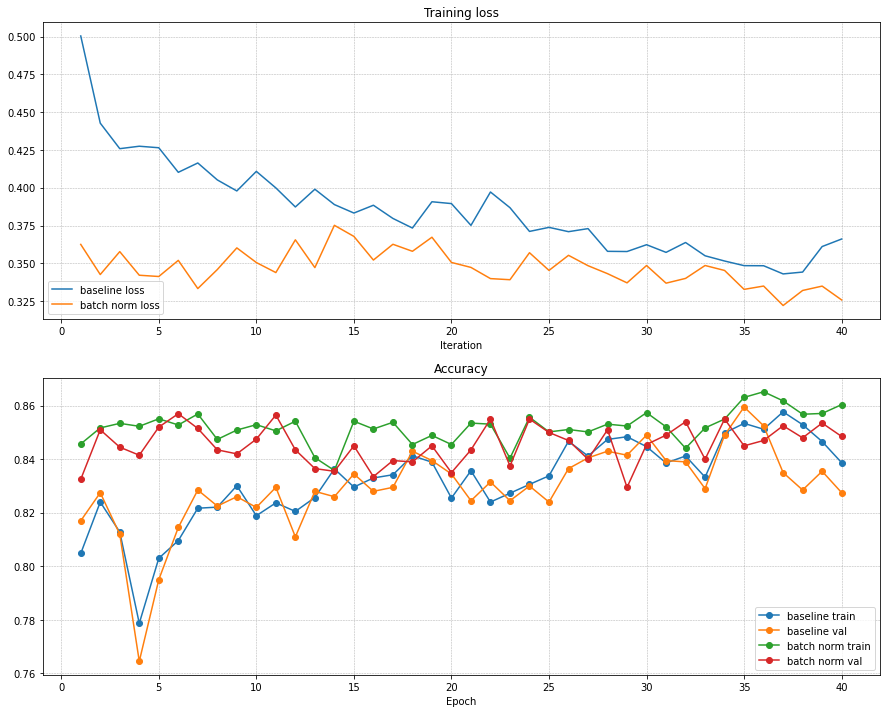

In [16]:
dim = range(1, len(hist["loss_train"])+1)

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(dim, hist["loss_train"], label='baseline loss')
plt.plot(dim, hist_batch_norm["loss_train"], label='batch norm loss')
plt.legend(loc='lower left')
plt.xlabel('Iteration')
plt.grid(linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(dim, hist["acc_train"], '-o', label='baseline train')
plt.plot(dim, hist["acc_val"], '-o', label='baseline val')
plt.plot(dim, hist_batch_norm["acc_train"], '-o', label='batch norm train')
plt.plot(dim, hist_batch_norm["acc_val"], '-o', label='batch norm val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()